Project: /overview/_project.yaml
Book: /overview/_book.yaml

<devsite-mathjax config="TeX-AMS-MML_SVG"></devsite-mathjax>
<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="使用 SavedModel 格式" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.GradientTape"/>
<meta itemprop="property" content="tf.Module"/>
<meta itemprop="property" content="tf.TensorSpec"/>
<meta itemprop="property" content="tf.Variable"/>
<meta itemprop="property" content="tf.config.experimental.set_memory_growth"/>
<meta itemprop="property" content="tf.config.list_physical_devices"/>
<meta itemprop="property" content="tf.constant"/>
<meta itemprop="property" content="tf.function"/>
<meta itemprop="property" content="tf.keras.applications.mobilenet.MobileNet"/>
<meta itemprop="property" content="tf.keras.applications.mobilenet.preprocess_input"/>
<meta itemprop="property" content="tf.keras.optimizers.experimental.SGD"/>
<meta itemprop="property" content="tf.keras.utils.get_file"/>
<meta itemprop="property" content="tf.keras.utils.img_to_array"/>
<meta itemprop="property" content="tf.keras.utils.load_img"/>
<meta itemprop="property" content="tf.saved_model.load"/>
<meta itemprop="property" content="tf.saved_model.save"/>
</div>

# 使用 SavedModel 格式

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/saved_model"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/saved_model.ipynb"> <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/saved_model.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/saved_model.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

SavedModel 包含一个完整的 TensorFlow 程序，包括训练的参数（即 <a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>）和计算。它不需要原始模型构建代码就可以运行，因此，对于使用 [TFLite](https://tensorflow.org/lite)、[TensorFlow.js](https://js.tensorflow.org/)、[TensorFlow Serving](https://tensorflow.google.cn/tfx/serving/tutorials/Serving_REST_simple) 或 [TensorFlow Hub](https://tensorflow.org/hub) 共享或部署非常有用。

您可以使用以下 API 以 SavedModel 格式保存和加载模型：

- 低级 <a href="https://www.tensorflow.org/api_docs/python/tf/saved_model"><code>tf.saved_model</code></a> API。本文档将详细介绍如何使用此 API。
    - 保存：<a href="https://www.tensorflow.org/api_docs/python/tf/saved_model/save"><code>tf.saved_model.save(model, path_to_dir)</code></a>
    - 加载：`model = tf.saved_model.load(path_to_dir)`
- 高级<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model"><code>tf.keras.Model</code></a> API。请参阅 [Keras 保存和序列化指南](https://tensorflow.google.cn/guide/keras/save_and_serialize)。
- 如果您只是想在训练中保存/加载权重，请参阅[检查点指南](./checkpoint.ipynb)。

小心：TensorFlow 模型是代码，对于不受信任的代码，一定要小心。请参阅[安全使用 TensorFlow](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md) 以了解详情。

## 从 Keras 创建 SavedModel

为便于简单介绍，本部分将导出一个预训练 Keras 模型来处理图像分类请求。本指南的其他部分将详细介绍和讨论创建 SavedModel 的其他方式。

In [2]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

2022-12-14 22:18:34.923603: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:18:34.923699: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:18:34.923709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

61306/61306 [==============================] - 0s 0us/step


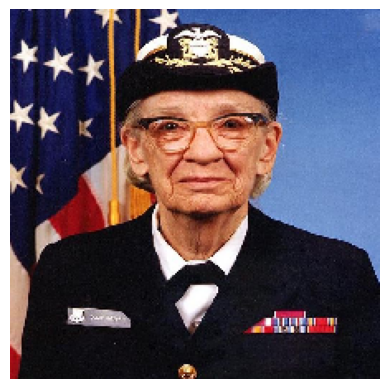

In [4]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.utils.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

我们会使用 Grace Hopper 的一张照片作为运行示例，并使用一个预先训练的 Keras 图像分类模型，因为它简单易用。您也可以使用自定义模型，后文会作详细介绍。

In [5]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


In [6]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

17225924/17225924 [==============================] - 0s 0us/step


Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


对该图像的顶部预测是“军服”。

In [7]:
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/mobilenet/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/mobilenet/1/assets


保存路径遵循 TensorFlow Serving 使用的惯例，路径的最后一个部分（此处为 `1/`）是模型的版本号——它可以让 Tensorflow Serving 之类的工具推断相对新鲜度。

您可以使用 <a href="https://www.tensorflow.org/api_docs/python/tf/saved_model/load"><code>tf.saved_model.load</code></a> 将 SavedModel 加载回 Python，并查看 Admiral Hopper 的图像是如何分类的。

In [8]:
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


导入的签名总是会返回字典。要自定义签名名称和输出字典键，请参阅[在导出过程中指定签名](#specifying_signatures_during_export)。

In [9]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


从 SavedModel 运行推断会产生与原始模型相同的结果。

In [10]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


## 在 TensorFlow Serving 中运行 SavedModel

可以通过 Python 使用 SavedModel（下文中有详细介绍），但是，生产环境通常会使用专门服务进行推理，而不会运行 Python 代码。使用 TensorFlow Serving 时，这很容易从 SavedModel 进行设置。

请参阅 [TensorFlow Serving REST 教程](https://tensorflow.google.cn/tfx/tutorials/serving/rest_simple)了解端到端 tensorflow-serving 示例。

## 磁盘上的 SavedModel 格式

SavedModel 是一个包含序列化签名和运行这些签名所需的状态的目录，其中包括变量值和词汇表。

In [11]:
!ls {mobilenet_save_path}

assets	fingerprint.pb	saved_model.pb	variables


`saved_model.pb` 文件用于存储实际 TensorFlow 程序或模型，以及一组已命名的签名——每个签名标识一个接受张量输入和产生张量输出的函数。

SavedModel 可能包含模型的多个变体（多个 `v1.MetaGraphDefs`，通过 `saved_model_cli` 的 `--tag_set` 标记进行标识），但这种情况很少见。可以为模型创建多个变体的 API 包括 [tf.Estimator.experimental_export_all_saved_models](https://tensorflow.google.cn/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) 和 TensorFlow 1.x 中的 `tf.saved_model.Builder`。

In [12]:
!saved_model_cli show --dir {mobilenet_save_path} --tag_set serve

2022-12-14 22:18:53.272172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:18:53.272277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:18:53.272288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


`variables` 目录包含一个标准训练检查点（参阅[训练检查点指南](./checkpoint.ipynb)）。

In [13]:
!ls {mobilenet_save_path}/variables

variables.data-00000-of-00001  variables.index


`assets` 目录包含 TensorFlow 计算图使用的文件，例如，用于初始化词汇表的文本文件。本例中没有使用这种文件。

SavedModel 可能有一个用于保存 TensorFlow 计算图未使用的任何文件的 `assets.extra` 目录，例如，为使用者提供的关于如何处理 SavedModel 的信息。TensorFlow 本身并不会使用此目录。

## 保存自定义模型

<a href="https://www.tensorflow.org/api_docs/python/tf/saved_model/save"><code>tf.saved_model.save</code></a> 支持保存 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 对象及其子类，如 `tf.keras.Layer` 和 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model"><code>tf.keras.Model</code></a>。

我们来看一个保存和恢复 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 的示例。

In [14]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

当您保存 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 时，任何 <a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> 特性、<a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 装饰的方法以及通过递归遍历找到的 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 都会得到保存。（参阅[检查点教程](./checkpoint.ipynb)，了解此递归便利的详细信息。）但是，所有 Python 特性、函数和数据都会丢失。也就是说，当您保存 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 时，不会保存 Python 代码。

如果不保存 Python 代码，SavedModel 如何知道怎样恢复函数？

简单地说，<a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 的工作原理是，通过跟踪 Python 代码来生成 ConcreteFunction（一个可调用的 <a href="https://www.tensorflow.org/api_docs/python/tf/Graph"><code>tf.Graph</code></a> 包装器）。当您保存 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 时，实际上保存的是 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 的 ConcreteFunction 缓存。

要详细了解 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 与 ConcreteFunction 之间的关系，请参阅 [tf.function 指南](function.ipynb)。

In [15]:
module_no_signatures_path = os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

Tracing with Tensor("x:0", shape=(), dtype=float32)
Saving model...
Tracing with Tensor("x:0", shape=(), dtype=float32)


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_no_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_no_signatures/assets


## 加载和使用自定义模型

在 Python 中加载 SavedModel 时，所有 <a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> 特性、<a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 装饰方法和 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 都会按照与原始保存的 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 相同对象结构进行恢复。

In [16]:
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

由于没有保存 Python 代码，所以使用新输入签名调用 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 会失败：

```python
imported(tf.constant([3.]))
```

<pre>ValueError: Could not find matching function to call for canonicalized inputs ((&lt;tf.Tensor 'args_0:0' shape=(1,) dtype=float32&gt;,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

### 基本微调

可以使用变量对象，还可以通过导入的函数向后传播。对于简单情形，这足以支持 SavedModel 的微调（即重新训练）。

In [17]:
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [18]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


### 一般微调

与普通 `__call__` 相比，Keras 的 SavedModel 提供了[更多详细信息](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details)来解决更复杂的微调情形。TensorFlow Hub 建议在共享的 SavedModel 中提供以下详细信息（如果适用），以便进行微调：

- 如果模型使用随机失活，或者是训练与推理之间的前向传递不同的另一种技术（如批次归一化），则 `__call__` 方法会获取一个可选的 Python 值 `training=` 参数。该参数的默认值为 `False`，但可将其设置为 `True`。
- 对于变量的对应列表，除了 `__call__` 特性，还有 `.variable` 和 `.trainable_variable` 特性。在微调过程中，`.trainable_variables` 省略了一个变量，该变量原本可训练，但打算将其冻结。
- 对于 Keras 等将权重正则化项表示为层或子模型特性的框架，还有一个 `.regularization_losses` 特性。它包含一个零参数函数的列表，这些函数的值应加到总损失中。

回到初始 MobileNet 示例，您可以看到一些具体操作：

In [19]:
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 83 trainable variables: conv1/kernel:0, conv1_bn/gamma:0, conv1_bn/beta:0, conv_dw_1/depthwise_kernel:0, conv_dw_1_bn/gamma:0, ...


In [20]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 54 non-trainable variables: conv1_bn/moving_mean:0, conv1_bn/moving_variance:0, conv_dw_1_bn/moving_mean:0, ...


## 导出时指定签名

TensorFlow Serving 之类的工具和 `saved_model_cli` 可以与 SavedModel 交互。为了帮助这些工具确定要使用的 ConcreteFunction，我们需要指定应用签名。<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model"><code>tf.keras.Model</code></a> 会自动指定应用签名，但是，对于自定义模块，我们必须明确声明应用签名。

重要提示：除非您需要使用 Python 将模型导出到 TensorFlow 2.x 之外的环境，否则您不需要明确导出签名。如果您在寻找为特定函数强制输入签名的方式，请参阅 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a> 的 [`input_signature`](https://tensorflow.google.cn/api_docs/python/tf/function#args_1) 参数。

默认情况下，自定义 <a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a> 中不会声明签名。

In [21]:
assert len(imported.signatures) == 0

要声明服务上线签名，请使用 `signatures` 关键字参数指定 ConcreteFunction。当指定单个签名时，签名键为 `'serving_default'`，并将保存为常量 <a href="https://www.tensorflow.org/api_docs/python/tf/saved_model#DEFAULT_SERVING_SIGNATURE_DEF_KEY"><code>tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY</code></a>。

In [22]:
module_with_signature_path = os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)

Tracing with Tensor("x:0", dtype=float32)
Tracing with Tensor("x:0", dtype=float32)
INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_signature/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_signature/assets


In [23]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())


['serving_default']

要导出多个签名，请将签名键的字典传递给 ConcreteFunction。每个签名键对应一个 ConcreteFunction。

In [24]:
module_multiple_signatures_path = os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_multiple_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_multiple_signatures/assets


In [25]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

['serving_default', 'array_input']

默认情况下，输出张量名称非常通用，如 `output_0`。为了控制输出的名称，请修改 <a href="https://www.tensorflow.org/api_docs/python/tf/function"><code>tf.function</code></a>，以便返回将输出名称映射到输出的字典。输入的名称来自 Python 函数参数名称。

In [26]:
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,
                    signatures={'serving_default': call_output})

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_output_name/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpe_362t4g/module_with_output_name/assets


In [27]:
imported_with_output_name = tf.saved_model.load(module_output_path)
imported_with_output_name.signatures['serving_default'].structured_outputs

{'custom_output_name': TensorSpec(shape=(), dtype=tf.float32, name='custom_output_name')}

## 在 C++ 中加载  SavedModel

SavedModel [加载器](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h)的 C++ 版本提供了一个从路径中加载 SavedModel 的 API，同时允许使用 SessionOption 和 RunOption。您必须指定与计算图相关联的标记才能加载模型。加载的 SavedModel 版本称为 SavedModelBundle，其中包含 MetaGraphDef 以及加载该版本所处的会话。

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &amp;bundle);
```

<a id="saved_model_cli"></a>

## SavedModel 命令行界面详解

使用 SavedModel 命令行界面 (CLI) 可以检查和执行 SavedModel。例如，您可以使用 CLI 来检查模型的 `SignatureDef`。通过 CLI，您可以快速确认与模型相符的输入张量的 dtype 和形状。此外，如果要测试模型，您可以通过 CLI 传入各种格式的样本输入（例如，Python 表达式），然后获取输出，从而执行健全性检查。

### 安装 SavedModel CLI

一般来说，通过以下两种方式都可以安装 TensorFlow：

- 安装预构建的 TensorFlow 二进制文件。
- 从源代码构建 TensorFlow。

如果您是通过预构建的 TensorFlow 二进制文件安装的 TensorFlow，则 SavedModel CLI 已安装到您的系统上，路径为 `bin/saved_model_cli`。

如果是从源代码构建的 TensorFlow，则还必须运行以下附加命令才能构建 `saved_model_cli`：

```
$ bazel build //tensorflow/python/tools:saved_model_cli
```

### 命令概述

SavedModel CLI 支持在 SavedModel 上使用以下两个命令：

- `show`：用于显示 SavedModel 中可用的计算。
- `run`：用于从 SavedModel 运行计算。

### `show` 命令

SavedModel 包含一个或多个模型变体（技术为 <a href="https://www.tensorflow.org/api_docs/python/tf/compat/v1/MetaGraphDef"><code>v1.MetaGraphDef</code></a>），这些变体通过 tag-set 进行标识。要为模型提供服务，您可能想知道每个模型变体中使用的具体是哪一种 `SignatureDef` ，以及它们的输入和输出是什么。那么，利用 `show` 命令，您就可以按照层级顺序检查 SavedModel 的内容。具体语法如下：

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

例如，以下命令会显示 SavedModel 中的所有可用 tag-set：

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

以下命令会显示 tag-set 的所有可用 `SignatureDef` 键：

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve
The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the
following keys:
SignatureDef key: "classify_x2_to_y3"
SignatureDef key: "classify_x_to_y"
SignatureDef key: "regress_x2_to_y3"
SignatureDef key: "regress_x_to_y"
SignatureDef key: "regress_x_to_y2"
SignatureDef key: "serving_default"
```

如果 tag-set 中有*多个*标记，则必须指定所有标记（标记之间用逗号分隔）。例如：

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu</pre>

要显示特定 `SignatureDef` 的所有输入和输出 TensorInfo，请将 `SignatureDef` 键传递给 `signature_def` 选项。如果您想知道输入张量的张量键值、dtype 和形状，以便随后执行计算图，这会非常有用。例如：

```
$ saved_model_cli show --dir \
/tmp/saved_model_dir --tag_set serve --signature_def serving_default
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['y'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: y:0
Method name is: tensorflow/serving/predict
```

要显示 SavedModel 中的所有可用信息，请使用 `--all` 选项。例如：

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --all&lt;br&gt;MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:&lt;br&gt;&lt;br&gt;signature_def['classify_x2_to_y3']:&lt;br&gt;  The given SavedModel SignatureDef contains the following input(s):&lt;br&gt;    inputs['inputs'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: x2:0&lt;br&gt;  The given SavedModel SignatureDef contains the following output(s):&lt;br&gt;    outputs['scores'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: y3:0&lt;br&gt;  Method name is: tensorflow/serving/classify&lt;br&gt;&lt;br&gt;...&lt;br&gt;&lt;br&gt;signature_def['serving_default']:&lt;br&gt;  The given SavedModel SignatureDef contains the following input(s):&lt;br&gt;    inputs['x'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: x:0&lt;br&gt;  The given SavedModel SignatureDef contains the following output(s):&lt;br&gt;    outputs['y'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: y:0&lt;br&gt;  Method name is: tensorflow/serving/predict</pre>

### `run` 命令

调用 `run` 命令即可运行计算图计算，传递输入，然后显示输出，还可以选择保存。具体语法如下：

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

要将输入传递给模型，`run` 命令提供了以下三种方式：

- `--inputs` 选项：可传递文件中的 NumPy ndarray。
- `--input_exprs` 选项：可传递 Python 表达式。
- `--input_examples` 选项：可传递 <a href="https://www.tensorflow.org/api_docs/python/tf/train/Example"><code>tf.train.Example</code></a>。

#### `--inputs`

要传递文件中的输入数据，请指定 `--inputs` 选项，一般格式如下：

```bsh
--inputs <INPUTS>
```

其中，*INPUTS* 采用以下格式之一：

- `<input_key>=<filename>`
- `<input_key>=<filename>[<variable_name>]`

您可以传递多个 *INPUTS*。如果确实要传递多个输入，请使用分号分隔每个 *INPUTS*。

`saved_model_cli` 使用 `numpy.load` 来加载 *filename*。*filename* 可能为以下任何格式：

- `.npy`
- `.npz`
- pickle 格式

`.npy` 文件始终包含一个 NumPy ndarray。因此，从 `.npy` 文件加载时，会将内容直接分配给指定的输入张量。如果使用 `.npy` 文件来指定 *variable_name*，则会忽略 *variable_name*，并且会发出警告。

从 `.npz` (zip) 文件加载时，您可以选择指定 *variable_name*，以便标识 zip 文件中要为输入张量键加载的变量。如果不指定 *variable_name*，SavedModel CLI 会检查 zip 文件中是否只包含一个文件。如果是，则为指定的输入张量键加载该文件。

从 pickle 文件加载时，如果未在方括号中指定 `variable_name`，则会将该 pickle 文件中的任何内容全部传递给指定的输入张量键。否则，SavedModel CLI 会假设该 pickle 文件中有一个字典，并将使用与 *variable_name* 对应的值。

#### `--input_exprs`

要通过 Python 表达式传递输入，请指定 `--input_exprs` 选项。当您没有现成的数据文件，而又想使用与模型的 `SignatureDef` 的 dtype 和形状相符的一些简单输入来对模型进行健全性检查时，这非常有用。例如：

```bsh
`<input_key>=[[1],[2],[3]]`
```

除了 Python 表达式，您还可以传递 NumPy 函数。例如：

```bsh
`<input_key>=np.ones((32,32,3))`
```

（请注意，`numpy` 模块已作为 `np` 提供。）

#### `--input_examples`

要传递 <a href="https://www.tensorflow.org/api_docs/python/tf/train/Example"><code>tf.train.Example</code></a> 作为输入，请指定 `--input_examples` 选项。对于每个输入键，它会获取一个字典列表，其中每个字典是 <a href="https://www.tensorflow.org/api_docs/python/tf/train/Example"><code>tf.train.Example</code></a> 的一个实例。字典键就是特征，而值则是每个特征的值列表。例如：

```bsh
`<input_key>=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### 保存输出

默认情况下，SavedModel CLI 会将输出写入 stdout。如果将字典传递给 `--outdir` 选项，则会将输出保存为以给定字典下的输出张量键命名的 `.npy` 文件。

使用 `--overwrite` 可重写现有输出文件。